<a href="https://colab.research.google.com/github/vanderbilt-data-science/foundational_MMA_workshop/blob/main/LLaVA_GalaxyZoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning LLaVA on Astronomical Data

In this notebook, we fine tune LLaVA (Large Language and Vision Assistant), a multimodal VLM (vision-language model) to be better adapted to describing astronomical images.

## **0. Basic Setup**

I'll assume this notebook is running on **Google colab**.

If so, we need to install some packages before we proceed. After the below cell runs, **restart the kernel** to be sure the notebook has access to these packages.

In [1]:
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q --upgrade ipywidgets==8.1.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import requests
import json
import os
from pathlib import Path
from PIL import Image
import time
from typing import Dict, List, Any
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt

from datasets import load_dataset
import pandas as pd, hashlib, tqdm

import torch
from torch.utils.data import Dataset
from transformers import AutoProcessor, LlavaForConditionalGeneration, TrainingArguments, Trainer

## **1. An Introduction to LLaVA**

[LLaVA](https://llava-vl.github.io/) (Large Language and Vision Assistant) is a model that was introduced by Liu et al. in the [Vision Instruction Tuning](https://arxiv.org/pdf/2304.08485) paper in late 2023.

It grafts a vision encoder onto a causal-LM so the model can “read” an image before predicting text. As such, it has multiple transformer components working in tandem:

| Component | What it is | Shape |
|-----------|------------|-------|
| **Vision encoder** | ViT-L/14 (CLIP) patch-embed layer, frozen | 3 × 336 × 336 → 257 × 1024 |
| **Projector** | 2-layer MLP (GELU) | 1024 → 4096 (LLaMA hidden) |
| **Language model** | Vicuna / LLaMA decoder-only Transformer | 4096-d, 32 layers (7 B) or pruned tiny (1.3 B) |

Before we get to training this model, we'll look thoroughly at its architecture and training procedure to understand what it's capable of!

> **Note:** In this tutorial, we'll be training on LLaVA-tiny, so we'll focus on the more fine-grained details there where specified. There's nothing special about LLaVA-tiny besides that these underlying components were chosen to be small - the same principles about how the models were stitched together and trained applies to the larger LLaVA versions as well.


### **The Vision Model**

In order for LLaVA to be able to "look" at images, it needs an encoder portion that turns an image into meaningful embeddings.

---

For this, LLaVA uses a **Vision Transformer [(ViT)](https://arxiv.org/pdf/2010.11929)** model — specifically, a large version known as **ViT-L/14**. This same vision encoder is used by both larger LLaVA models and LLaVA-tiny.

**ViT-L/14**:
  - Has 24 transformer blocks (the "L" = the "Large" version).
  - Splits the image into patches of **14 × 14 pixels** (the “14”).
  - Processes images of **336 × 336 pixels**, which gives you **24 × 24 = 576 patches**, plus one extra special token (577 total tokens).
  
Each of these patches is treated a bit like a "visual word" — it gets turned into a **1024-dimensional vector** that summarizes the visual content in that small chunk of the image.



#### **How a ViT Patches Images**

Let's take a step back and look at how a ViT turns an image into a tokenized sequence.

Images are of course made of *pixels* - and ViT starts with images that are **336x336 pixels**. Transformer architectures fundamentally want to make use of *sequences*. While pixels are naturally numeric, flattening all pixels of an image, even of 336x336 (which is relatively small!) = 112896 values - too large to efficiently process, and probably not worth it in terms of the information actually contained in all individual pixel values.

The core innovation behind ViT is to sequence **patches** of the image. Small enough patches of an image can be considered to contain approximately one "thing" and thus can be treated as a single region of focus in the image. 24 x 24 patches taken over an image that's 336x336 = 576 values - much better.

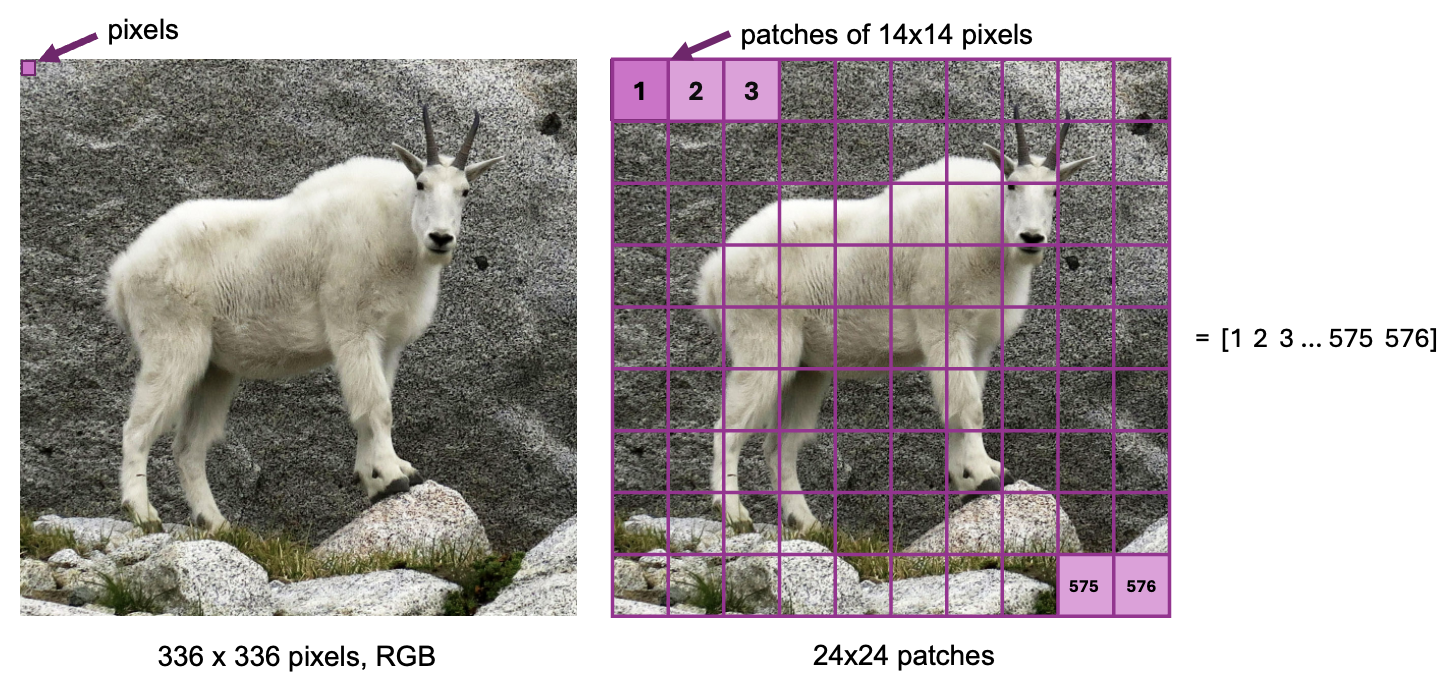

In [3]:
from IPython.display import Image, display
display(Image("pixels_vs_patches.png", width=1000))

#### **How Patches are Transformed**

The next step is to use those patches to actually get meaningful information about the image.

For each patch {1, 2, .... 576}:

1. Flatten and Project

- Flatten it into a single 1D vector of pixel values
- Pass that through a **learnable linear projection layer**, which maps that pixel sequence into a **1024-dimensional embedding** that is a summary of the patch's visual contents.


2. Add Positional Information

- Each patch has a corresponding **learned positional embedding** — a fixed vector (same shape as the patch embedding) that represents its location.
- The model adds this positional vector to the patch embedding.

So for each patch:

[embedding] = [patch vector] + [position vector]

This lets the model reason about *spatial layout*, not just content.

<details>
<summary>📌 Note: Why 196 → 1024 projection?</summary>

You might be wondering why we do the projection to 1024 values from 196.
We walked about how 336x336 pixels -> 112896 is a "waste", but 24x24 patches of size 1024 = 589824 - *more* information than just our pixel values!

So **why** do we do this?

It might seem like just an inflation of the data, but doing this projection makes the information more **richer** and more suitable for the Transformer to use. the 1024 vectors that come out of the linear projection layer are contextualized, rich embeddings of the pixel information, and provide **more meaningful** information than pixel values alone.

- Transformers expect high-dim input (e.g., LLaMA uses 4096-d text tokens)
- Raw pixels are low-level; projection lets the model learn abstract features
- The number of *tokens* works out to still just 576 (one per patch), so compute stays reasonable (we'll see this in more detail soon)

So think of this transformation like it's converting an image patch into a dense “visual word.”

</details>


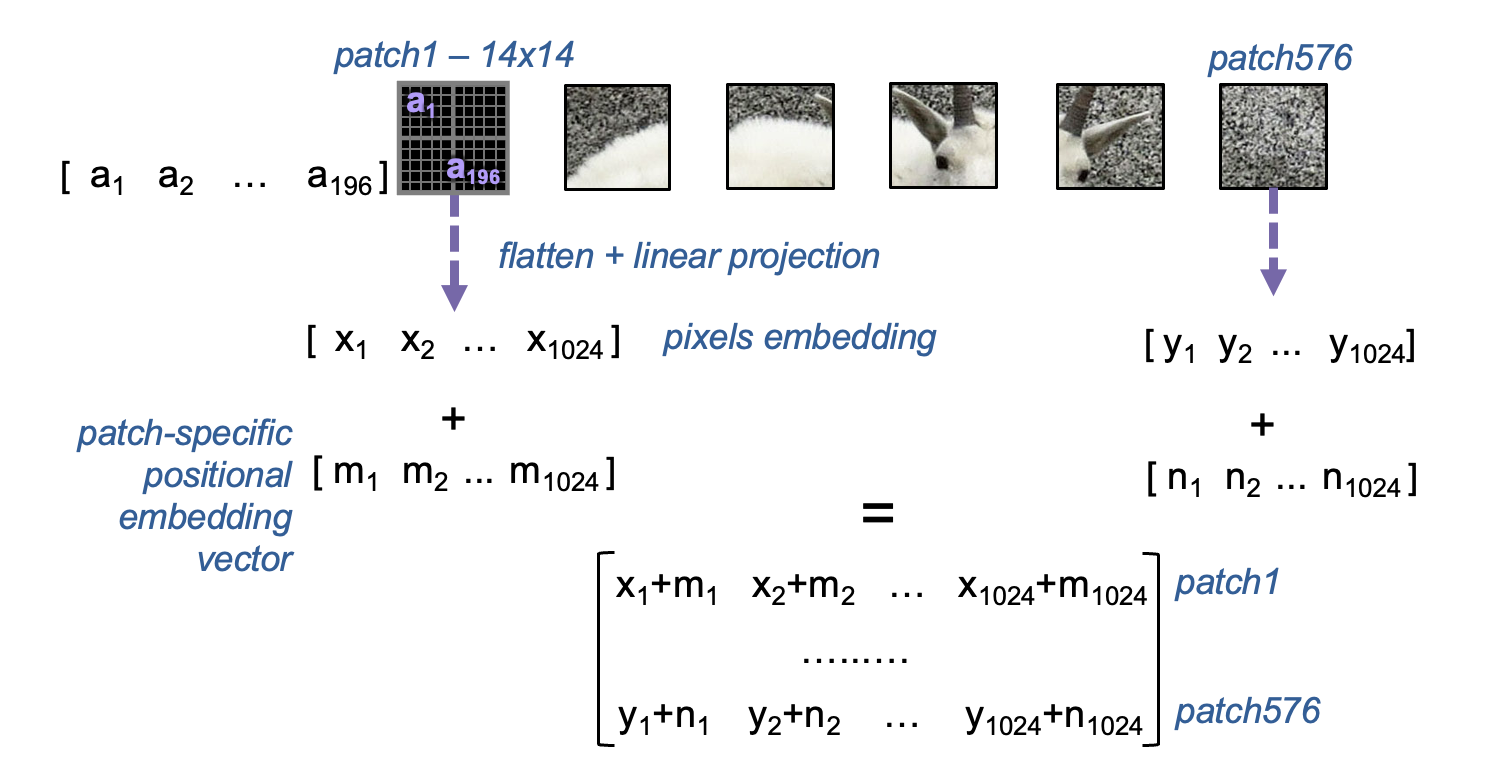

In [7]:
display(Image("processing_patches.png", width=800))

#### **How Each Transformer Layer Operates**

Once we have this rich embedding for each of our patches, it's time for the core transformer architecture to do its thing. Each transformer layer works to model **relationships between patches** using self-attention.

At each layer:

1. **Attention mechanism**  
   Each patch embedding "looks" at every other patch embedding (including itself), and decides how much attention to pay to each one.  
   → This creates a big 576 × 576 matrix of attention scores.  
   → Each patch gets updated as a **weighted combination** of all the others.

2. **Fully connected layer (FCN)**  
   After attention, each updated embedding goes through a small feedforward neural network (the same one for every patch).  
   This adds extra non-linearity and depth.

3. **Output**  
   We now have a new set of patch embeddings — same shape (576 × 1024), but now **contextualized**:  
   Each patch now contains information not just about itself, but also about the rest of the image.

In ViT-L which has 24 layers, this process is repeated 24 times.
And so, the embedding of an image coming out of ViT is size **576 x 1024** representing 576, 1024-size embeddings that describe the image.

<details>
<summary>📌 Revisiting that 1024 Dimension:</summary>

Ok, the point that we made above:

"The number of tokens works out to still just 576 (one per patch), so compute stays reasonable"

might not have immediately made sense. And as we just discussed, every layer of ViT will compute over this 576 x 1024 matrix, so we'll constantly be passing around those 589824 values of information. It might have made sense why this projection to 1024 is *more meaningful*, but how is it also *more computationally efficient* than dealing with our raw pixel values (112896)?

This is because, thanks to the attention mechanism, transformers scale *quadratically* with sequence length ($L$) but only *linearly* with embedding dimension ($D$). This really comes down to the fact that the attention mechanism contains a **dot product** calculation of an $L \times D$ and $D \times L$ matrix, which requires that every row be multiplied by every column. Therefore, every increase in $L$ requires $L^2$ calculations.

In ViT, the **token count** that assigns one token per patch is our sequence length. So, we save tons of compute using patches *to make the sequence length smaller for the transformer layers*. That’s why patch-based tokenization is critical — if we instead kept an 112896 sequence of pixels, using attention on it would be infeasible.
</details>

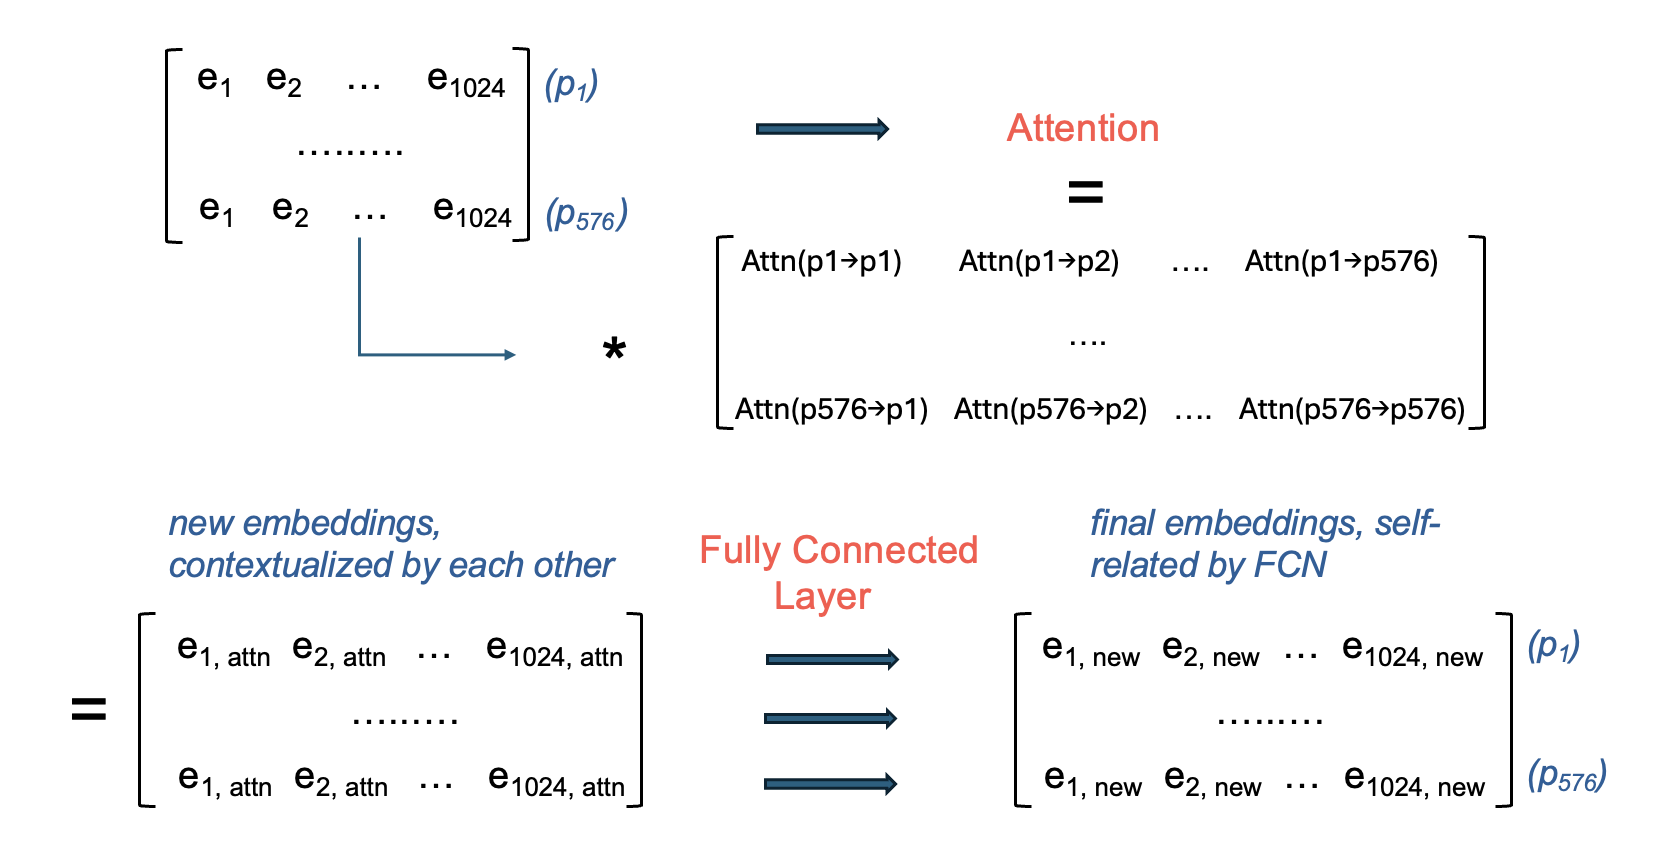

In [9]:
display(Image("transformer_layer.png", width=900))

### **The Language Model**

The other half of LLaVA is of course the language understanding part. For LLaVA, the language model component is a decoder-only Transformer, whose job is to turn embeddings into words.

---

LLaVA relies on a LLaMA model for its language component. In the case of LLaVA-tiny, it simply uses a pruned-down version of LLaMA-7B:

| Model | Layers | Hidden size | # Params |
|-------|--------|--------------|----------|
| LLaMA-7B | 32 | 4096 | 7.0 B |
| Tiny LLaVA | 13 | 4096 | ~1.3 B |

So the architecture is the same — just fewer layers, making it small enough to fit and train on a modest GPU.


#### **How Decoder Inputs are Created**

The job of a decoder-based language model is to take a sequence of tokens and turn it into language.

The input might be:

```text
<image> Describe this galaxy.
```

This is tokenized, both the image (we'll dicuss) and the words "Describe this galaxy" by a **tokenizer** into a numerical sequence that the decoder layers can handle.

The job of the tokenizer is to create meaningful embeddings for words. Each word token in the description is embedded into a vector that contains richer embeddings than just the word itself. Tokenizers are trained specifically to do this task.

The embedding dimension ($D$), 4096, is fixed by the tokenizer and therefore the model. The sequence length ($L$) depends on how many things there are to tokenize - it depends on the image size (although this is fixed to 336x336), and how many words we gave in our prompt to LLaVA. In practice, LLM's have some maximum sequence length, $L_{max}$ that they can handle.

#### **How a Decoder Layer Operates**

A decoder transformer generates words one by one - every new token generated is conditioned on what came before.

The primary computation for an decoder layer is the same as for any other transformer layer, except *masked attention* is used instead. This zeros out attention between the tokens and others tokens that are later in the sequence to them.

The function of this is two-fold.
- During training, the model can't "cheat" by allowing tokens to attend to ones that they shouldn't know exist yet.
- During inference, tokens in the past are **fixed** (already generated, or were input) - there's no value in attending them to future tokens - you can't do anything to change them now anyway.

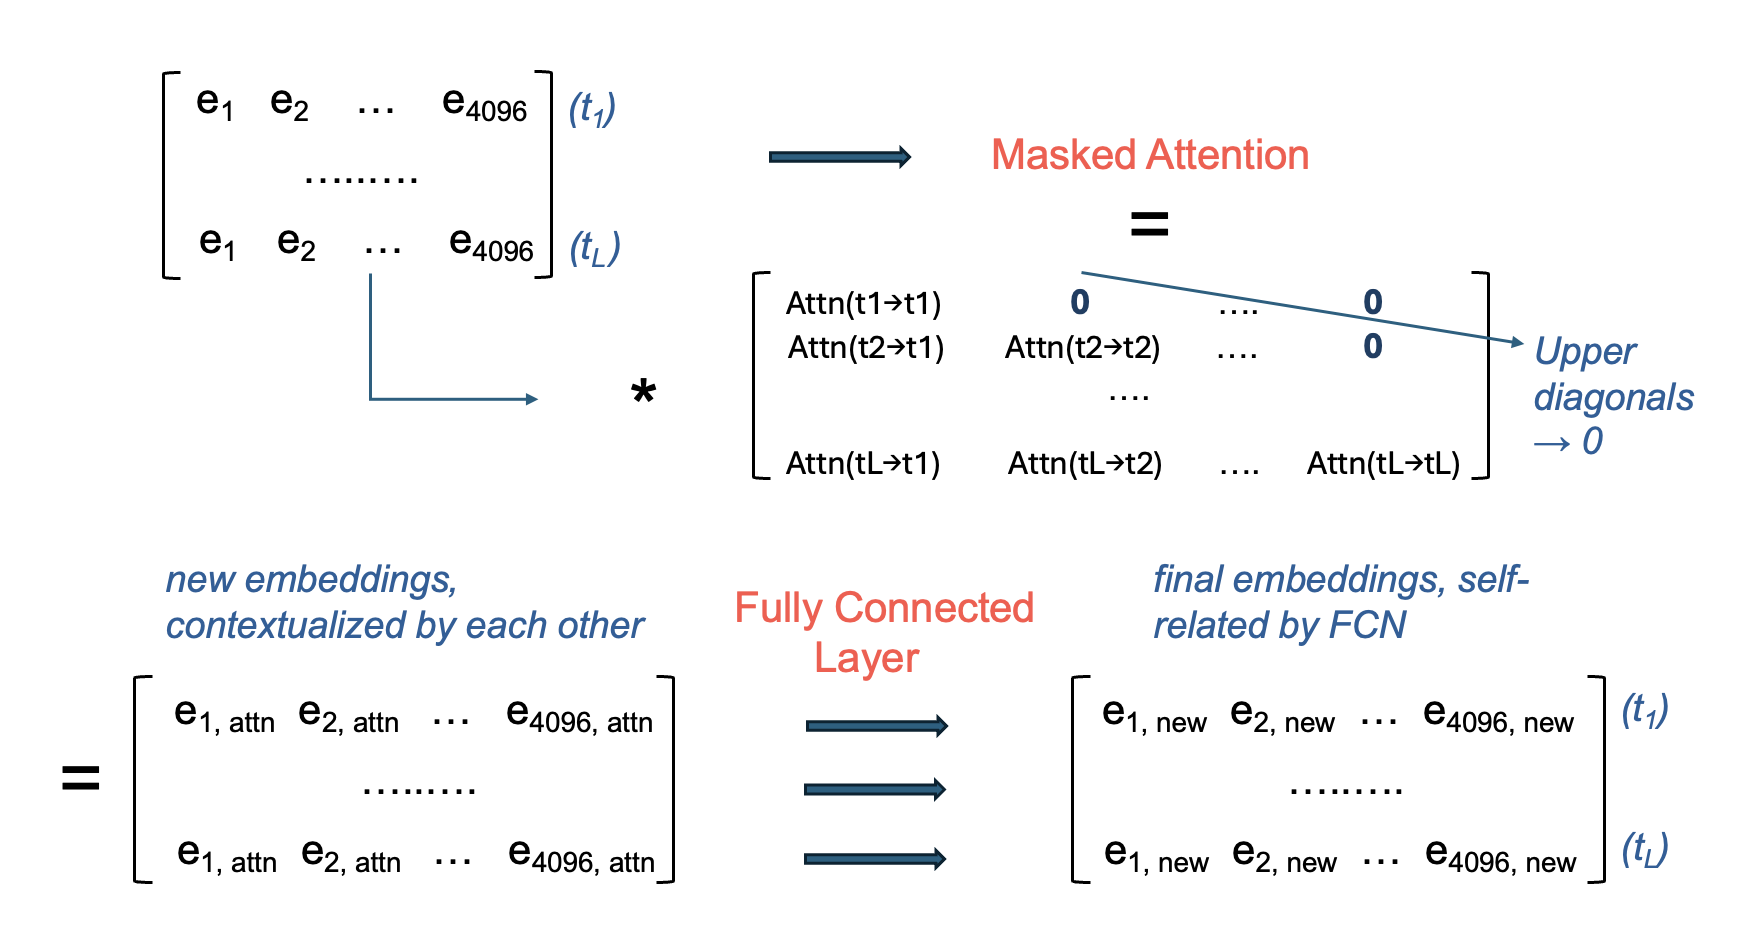

In [6]:
display(Image("decoder_layer.png", width=900))

#### **How the Next Token is Generated**

The text decoder of LLaVA-tiny has 13 layers, so the above process happens 13 times, and coming out of the decoder layers is an $L \times 4096$ matrix.

This is turned into a *prediction of the next token* by:
- taking the embedding for the most recent (L-th) word (remember, this has now been contextualized many times by all the words before it)
- it's passed to a linear projecion layer to get a vector of length `vocab_size` (typically ~32k)
- this is typically passed to a softmax function to produce, for all words in the vocabulary, the probability that a given word is the next token
- with some temperature allowing for randomness, a token of high probability is chosen.

When this is appended to the sequence, L becomes L + 1, and the whole process of 13 decoder layers starts again with the new sequence. This gradually produces the output that you see when asking LLaVA about an image!

### **The Fusion Mechanism**

It's finally time to talk about the core "technology" behind a model like LLaVA - the fusion mechanism. Up until now, we have a "regular"  ViT that processes an image and a "regular" large language model that makes text. The fusion mechanism is what connects them.

Since LLaVA's task is to process and understand an image to be able to create text contextualized by it, the job of the fusion mechanism is really to turn the image emedding into something that the language model understands.

In reality, the fusion mechanism is extremely simple — it’s just a linear projection layer that maps the embeddings from the ViT into the same vector space as the language model’s token embeddings. This lets the image patches act like “visual tokens” that the language model can attend to just like words.

---

LLaVA uses a **simple fusion mechanism** to do this:
- The final output of the vision encoder is a sequence of 576 visual tokens (one per patch), each a 1024-dimensional vector.
- These are passed through a small **projection layer** (usually an MLP) that **maps 1024 → 4096**, matching the LLaMA embedding size.
- The projected visual tokens are then **prepended** to the input tokens of the language model, as if they were special “image tokens.”

The LLM then attends to these visual tokens just like text, using self-attention across the combined sequence. This way, the LLM gets the visual tokens in a space that's already meaningful to it, but also get's *told* that they are visual tokens, so that it can understand how to use them during the training phase.

This approach might seem super simple (and it is!) but it's also very flexible, and surprisingly effective with the right training, as we’ll see.

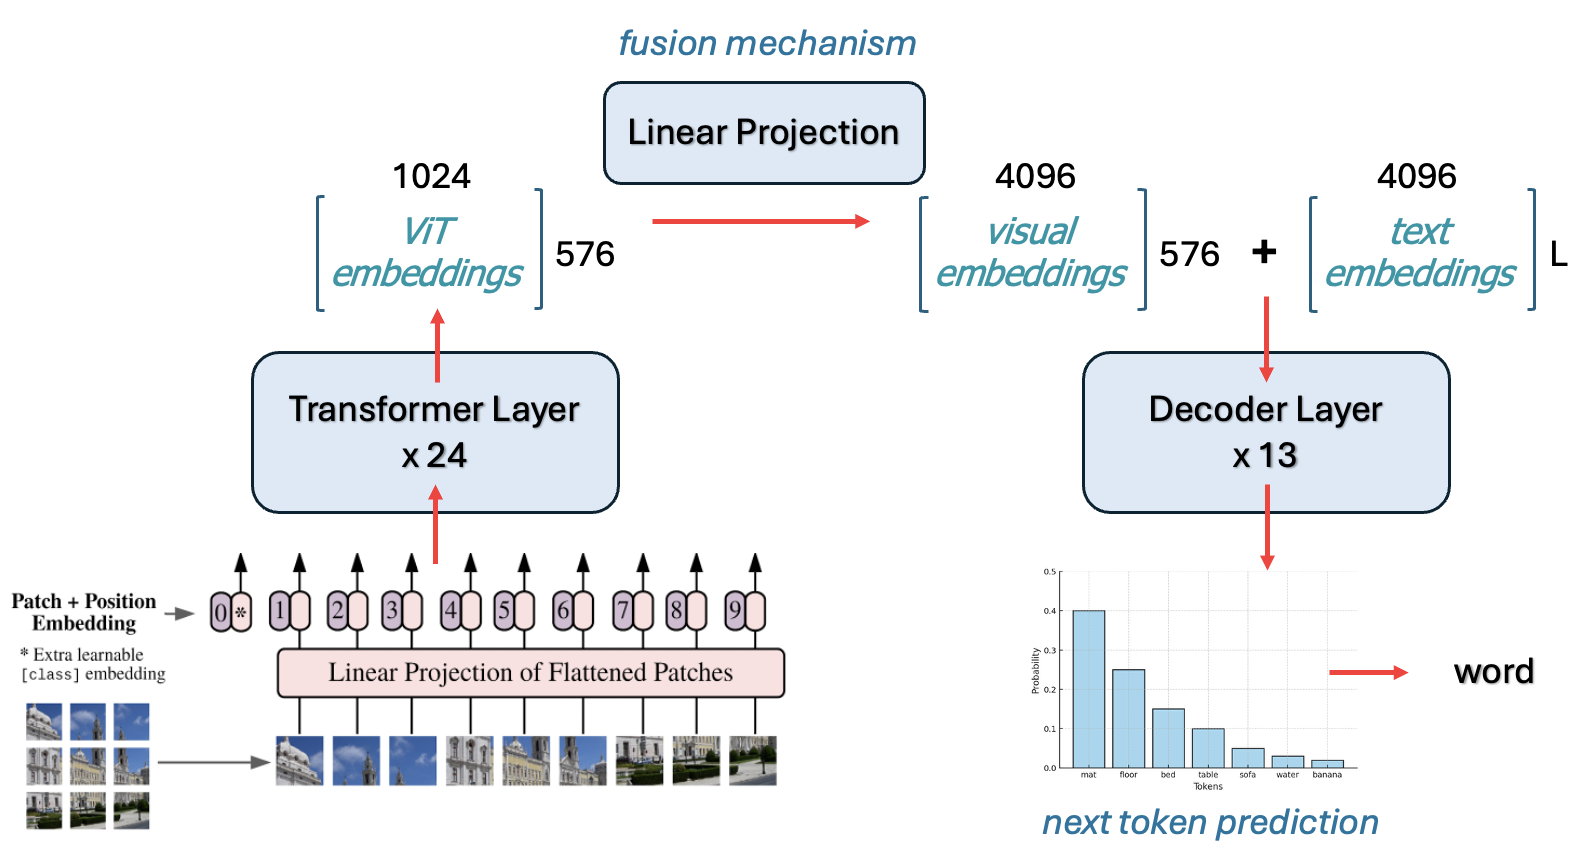

In [7]:
display(Image("llava_pipeline.png", width=1000))

### **Training LLaVA**

The final thing to discuss is *how something like this gets trained*. A ViT and a LLaMA already understand their respective datatypes, so training has to make sure to work with, and not against that knowledge.

First, we'll talk about an important element of how LLaVA was trained that happens, *even before the pipeline is trained all together* that sets LLaVA up for success.

---

**ViT-L/14 Was Trained With Contrastive Learning**
LLaVA doesn't train the vision encoder from scratch — it inherits a ViT model that was already trained using CLIP (Contrastive Language-Image Pretraining), created by OpenAI.

- CLIP was trained on 400 million (image, text) pairs scraped from the internet (web pages with associated images and alt text, captions, etc.).

- The image goes through a ViT (like ViT-L/14).

- The text goes through a Transformer-based text **encoder**. This turns text -> embeddings, but importantly, *is not generative*.

- Then it’s trained using a contrastive loss, which aims to push the embeddings of an image and the embeddings of its corresponding caption closer in embedding space, and embeddings that don't correspond further away.

**The result:** ViT-L/14 learns to produce embeddings that are already aligned with natural language text embeddings, so the 576x1024 embeddings coming out of the ViT are already "language-aligned" to some extent — they live in the same conceptual space as captions.

#### **How the Fusion Mechanism is Trained**

Because ViT was trained with CLIP to understand images, *and* to put them in a text-friendly space, it's frozen during training.

The first phase of LLaVA training teaches the fusion mechanism to align and the language model to accept tokens.

- Dataset: image–caption pairs (COCO, CC3M, etc.)
- Input: an image
- Target Output: the corresponding caption (as tokens)
- Loss: language modeling loss (cross-entropy on the caption tokens)

During this training phase, the weights of the fusion mechanism layer are trained (ViT output → LLM input space), and the language model is lightly tuned to learn what to do with image tokens.
> <summary>"lightly tuned" meaning using a low learning rate, PEFT, or unfreezing only certain layers, depending on the LLaVA version. The idea here is to make use of what the language model already knows as best as possible.</summary>

This is the training phase where LLaVA learns to “talk about” images at all.

#### **How It's Prompt-Trained**

The first phase of training teaches LLaVA to write a caption for a corresponding image. But LLaVA is also able to accept prompt instructions, i.e. you can include with your image "Describe this image" or "What's interesting about this picture?"

For this to work, the language part of LLaVA needs to be **instruction fine-tuned**. We won't get into the details here since it's a bit outside of the scope of how LLaVA works specifically, but this phase of training is just meant to align the language part of the model - *both* ViT and the fusion mechanism are frozen while the language model learns to follow instructions.


----

And that's it!! Hopefully, you should now have a concrete understanding of how information flows through a model like LLaVA, and how we train a model to this sort of multi-modal alignment!

## **2. Dataset Creation**

In this notebook, we'll be fine tuning our own LLaVA to understand astronomical images. Since LLaVA is trained on image and image caption pairs, we need a similar data structure to train it with.

High quality image captions that contain real astronomical descriptions are ideal. For the purposes of this tutorial, we'll be gathering data from [Galaxy Zoo 2](https://huggingface.co/datasets/mwalmsley/gz2/tree/main) - a set of galaxy images and their morphological classifications. We'll build the morphological classifications into captions as best as we can. While not *totally* ideal for real, quality fine tuning, it should be sufficient to see some basic changes in the model.

---

#### **The Data Source**: GalaxyZoo2

* **Source**  Hugging Face dataset `mwalmsley/gz2` (172 k SDSS galaxy JPGs + volunteer morphology votes).  
* **Images**  JPEG cut-outs around each galaxy.  
* **Labels converted to text**  
  * _Elliptical / Spiral_ (+ bar, arm count, bulge, merger/odd)  
  * Axis-ratio for ellipticals (“round”, “elongated”)  
* **Caption length**  ≈ 5-20 words typically.  


### **Create Dataset Collector**

The below code:

1. downloads **N** examples (set by `N`),  
2. rescales to 336 × 336,  
3. writes `gz2_llava.jsonl` for LLaVA.

#### **LLaVA's Training Format**

LLaVA expects training data in a **conversation format** that mimics how humans discuss images. Each training example contains:

1. **Human question/prompt** about an image
2. **LLM model response** with detailed explanation
3. **Image reference** linking to the visual content

In the below code, you can set `N` - the number of images to be downloaded.

In [3]:
# ------------------------------------------------------------------ paths
root   = Path("gz2_llava_hf");  imgs = root / "images"
root.mkdir(exist_ok=True); imgs.mkdir(exist_ok=True)

# ------------------------------------------------------------------ load a subset (change N for more)
N      = 2000                     # <-- set this to any size you want
ds     = load_dataset("mwalmsley/gz2", split="train").select(range(N))

# ------------------------------------------------------------------ helper for captions  (HF column names)
def describe(r):
    out = []

    # === main class =========================================================
    smooth = r["smooth-or-featured-gz2_smooth_fraction"] > 0.6
    if smooth:
        out.append("This is an image of an elliptical galaxy")
        # axis ratio
        if   r["how-rounded-gz2_round_fraction"]        > .5: out.append("nearly round in shape")
        elif r["how-rounded-gz2_in-between_fraction"]   > .5: out.append("moderately elongated in shape")
        elif r["how-rounded-gz2_cigar_fraction"]        > .5: out.append("highly elongated in shape")
    else:
        out.append("This is an image of a spiral galaxy")
        if r["bar-gz2_yes_fraction"] > .5:
            out.append("with a central bar")
        if   r["spiral-arm-count-gz2_2_fraction"]       > .5: out.append("with two arms")
        elif r["spiral-arm-count-gz2_3_fraction"]       > .5: out.append("with three arms")
        elif r["spiral-arm-count-gz2_more-than-4_fraction"] > .5:
            out.append("with many arms")

    # bulge prominence / shape
    if r["bulge-size-gz2_obvious_fraction"]             > .5: out.append("prominent bulge at its center")
    if r["bulge-shape-gz2_boxy_fraction"]               > .5: out.append("boxy bulge at its center")

    # mergers / oddities
    if r["something-odd-gz2_yes_fraction"]              > .4: out.append("disturbed or merging with another galaxy")

    return ", ".join(out) + "."


# ------------------------------------------------------------------ build records
records = []
for ex in tqdm.tqdm(ds, desc="saving"):
    img = ex["image"].convert("RGB").resize((336, 336))
    fname = imgs / f"{hashlib.md5(ex['id_str'].encode()).hexdigest()}.jpg"
    img.save(fname, "JPEG", quality=85)
    caption = describe(pd.Series(ex))
    records.append({"image": str(fname), "text": caption})

# ------------------------------------------------------------------ dump jsonl
with open(root / "gz2_llava.jsonl", "w") as f:
    for r in records:
        f.write(json.dumps(r) + "\n")

print(f"✓ wrote {len(records)} pairs → {root/'gz2_llava.jsonl'}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/261M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/172377 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/18797 [00:00<?, ? examples/s]

saving: 100%|██████████| 2000/2000 [00:12<00:00, 164.96it/s]

✓ wrote 2000 pairs → gz2_llava_hf/gz2_llava.jsonl


After running this data collection, you should have:

```
gz2_llava_hf/
├── gz2_llava.jsonl.json          # Dataset with all metadata
├── images/                      # Downloaded astronomical images
│   ├── 00c1591a613183ff21a67f79a29b5940.jpg
│   ├── 00fd8380b58f4c5086f655e646e0d5a0.jpg
│   └── ...
```

Each entry in `gz2_llava.jsonl` contains:
- `image`: Path to the astronomical image
- `text`: description of galaxy morphology


### **Inspect Downloaded Data**

Now, let's look a at a random example in our newly-downloaded dataset.

This cell can be re-run to inspect a new random image.

This is an image of an elliptical galaxy, moderately elongated in shape.


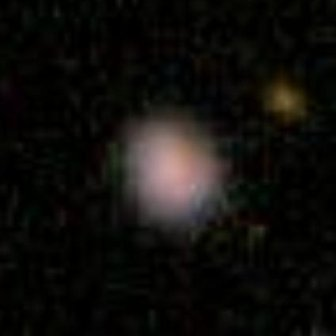

In [4]:
import json, random
from PIL import Image
from IPython.display import display

# path to the JSON-Lines file you just wrote
JSONL = "gz2_llava_hf/gz2_llava.jsonl"      # adjust if you used a different folder

# grab one random record (or change to lines[0] for the first)
with open(JSONL) as f:
    rec = json.loads(random.choice(f.readlines()))

print(rec["text"])          # caption
display(Image.open(rec["image"]))  # shows the image in a notebook

### **Create the Dataset Class**

The final step is to make sure we have a dataset class set up for use with the model.

We need to convert our conversation data into PyTorch's training format. This cell creates a Dataset class that loads images, processes text, and tokenizes everything for LLaVA training.

In [2]:
class GZ2LLaVADataset(Dataset):
    def __init__(self, jsonl_path, processor):
        with open(jsonl_path) as f:
            self.data = [json.loads(l) for l in f]
        self.proc = processor
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        item  = self.data[idx]
        img   = Image.open(item["image"]).convert("RGB")
        text  = f"USER: <image>\nDescribe this galaxy. ASSISTANT: {item['text']}"
        enc   = self.proc(text=text, images=img, return_tensors="pt")
        return {k: v.squeeze() for k,v in enc.items()} | {"labels": enc["input_ids"].squeeze()}

### **Step 3: Perform Full Fine Tuning on LLaVA-Tiny**

This cell loads the TinyLLaVA model and creates helper functions for testing. We'll use these functions to compare the model's responses before and after training.

We take tiny LLaVA from this [HuggingFace repository](https://huggingface.co/bczhou/tiny-llava-v1-hf).

TinyLLaVa is a smaller version of LLaVA with

#### **Setup and Prepare TinyLLaVA for Tuning**

#### `LlavaForConditionalGeneration.from_pretrained(...)`
* **Weights & config** are pulled from 🤗 Hub repo **`bczhou/tiny-llava-v1-hf`**.  
  * It is a 1.3 B-parameter Vicuna-7B **layer-pruned** down to 1.3 B + a vision patch-embedding & cross-attention blocks → ≈ 2.1 GB in fp16, 4.2 GB in fp32.
* `device_map="auto"` = 🤗 Accelerate loads each layer on the first GPU/CPU with room.
* `torch_dtype=torch.float32` tells HF to **up-cast** fp16 weights to fp32 when opening—slower, but avoids NaN/overflow on consumer GPUs.

In [6]:
from transformers import AutoConfig
cfg = AutoConfig.from_pretrained("bczhou/tiny-llava-v1-hf")
print(cfg.model_type)            # => 'llava'
print(cfg.vision_config)         # ViT‐like patch embed {img_size: 336, patch:14}
print(sorted(cfg.to_dict().keys()))        # list available keys

config.json: 0.00B [00:00, ?B/s]

llava
CLIPVisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "quick_gelu",
  "hidden_size": 1024,
  "image_size": 336,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 14,
  "projection_dim": 768,
  "transformers_version": "4.54.0",
  "vocab_size": 32000
}

['_name_or_path', 'add_cross_attention', 'architectures', 'bad_words_ids', 'begin_suppress_tokens', 'bos_token_id', 'chunk_size_feed_forward', 'cross_attention_hidden_size', 'decoder_start_token_id', 'diversity_penalty', 'do_sample', 'early_stopping', 'encoder_no_repeat_ngram_size', 'eos_token_id', 'exponential_decay_length_penalty', 'finetuning_task', 'forced_bos_token_id', 'forced_eos_token_id', 'id2label', 'ignore_index', 'image_seq_length', 'image_token_index', 'is_decoder', 'is_encoder_decoder', 'label2id', 'length_penalty', 'ma

In [3]:
def setup_tiny_llava():
    """One function to set everything up"""
    print("Setting up TinyLLaVA...")

    # Load model and processor
    model_id = "bczhou/tiny-llava-v1-hf"

    model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.float32,  # Use FP32 instead of FP16
        device_map="auto"
    )

    processor = AutoProcessor.from_pretrained(model_id)

    # Fix patch_size issue
    if processor.patch_size is None:
        processor.patch_size = 14
        print("✓ Fixed patch_size")

    print("✓ Model and processor ready")
    return model, processor

def test_model(model, processor, test_image_path):
    """Simple test function"""
    image = Image.open(test_image_path).convert('RGB').resize((336, 336))

    inputs = processor(
        text="USER: <image>\nWhat is this? ASSISTANT:",
        images=image,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=50, do_sample=False)

    response = processor.decode(outputs[0], skip_special_tokens=True)
    return response.split("ASSISTANT:")[-1].strip()

#### **Full Fine Tuning Training Loop**

Now, we are ready to set up the loop to perform full fine tuning!

Huggingface makes this super easy by just defining a `trainer`. But first, we'll need to define the training arguments. This sets up exactly how the training will proceed, and it's where we can set hyperparameters, determine what outputs we want to see, where the model will save, all of that!

In [8]:
# Training configuration - full FP32 to avoid all gradient issues
training_args = TrainingArguments(
    output_dir="./tiny-llava-trained",         # Where to save model checkpoints
    num_train_epochs=3,                        # How many times to go through the dataset
    per_device_train_batch_size=1,             # Process 1 example at a time (small for memory)
    learning_rate=1e-5,                        # How fast the model learns (small = careful)
    logging_steps=500,                         # Print progress every N training steps
    save_strategy="no",                        # Don't save checkpoints (workshop demo only)
    eval_strategy="no",                        # Don't evaluate during training (keep simple)
    remove_unused_columns=False,               # Keep all data columns for LLaVA
    fp16=False,                                # Disable half-precision (avoids gradient issues)
    bf16=False,                                # Disable bfloat16 (avoids gradient issues)
    report_to="none",                          # Don't send metrics to tracking services
    dataloader_num_workers=0,                  # Use main thread only (avoids multiprocessing issues)
    dataloader_pin_memory=False                # Disable memory pinning (avoids GPU memory issues)
)

Then, we're finally ready to set it training.

Below, we'll set the model and processor up, create the dataset from our formatted JSON, and start training.

This cell will also show us what the model's response to a given image looked like both before and after training, so we can see if it got any better.

🚀 Starting TinyLLaVA full fine tuning....
Setting up TinyLLaVA...


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

✓ Fixed patch_size
✓ Model and processor ready

Testing BEFORE training:


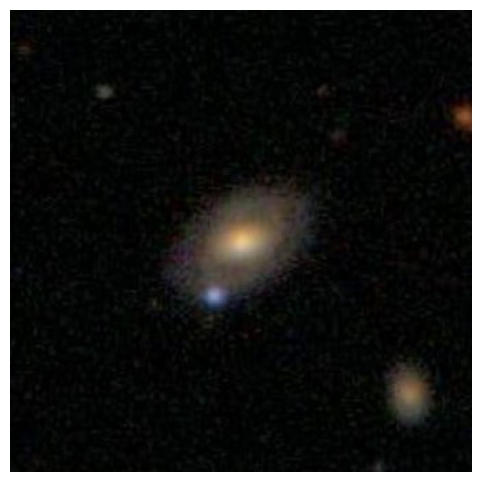

BEFORE: The image features a large, bright, and colorful star cluster in the middle of a dark, empty space. The star cluster is surrounded by a vast, dark, empty space, which appears to be a vast, empty, and dark galaxy

Starting training...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,0.510400
1000,0.005400
1500,0.005000
2000,0.005100
2500,0.004800
3000,0.004800
3500,0.004700
4000,0.004700
4500,0.004700
5000,0.004500


✓ Training completed!

Testing AFTER training:
AFTER: This is an image of an elliptical galaxy, moderately elongated in shape. prominent bulge at its center. This disturbed or merging with another galaxy. disturbed or merging with another galaxy. This is
TRUE: This is an image of a spiral galaxy, prominent bulge at its center, disturbed or merging with another galaxy.


In [9]:
print("🚀 Starting TinyLLaVA full fine tuning....")
print("=" * 30)

# Setup using our setup function
model, processor = setup_tiny_llava()

# Create the dataset from our LLaVA-formatted JSON
dataset = GZ2LLaVADataset("gz2_llava_hf/gz2_llava.jsonl", processor)

# ------Test before training -----
print("\nTesting BEFORE training:")
sample_item = dataset.data[0]
test_image = f"{sample_item['image']}"
before_response = test_model(model, processor, test_image)

plt.figure(figsize=(8, 6))
img = Image.open(test_image)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"BEFORE: {before_response}")
# -------------------------------

# Set up the trainer with our args
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    processing_class=processor
)

print("\nStarting training...")
trainer.train()
print("✓ Training completed!")

# Test after training
print("\nTesting AFTER training:")
after_response = test_model(model, processor, test_image)
print(f"AFTER: {after_response}")

print(f"TRUE: {sample_item['text']}")

TRUTH: This is an image of an elliptical galaxy, nearly round in shape.
PREDICTED: This is an image of an elliptical galaxy, moderately elongated in shape. prominent bulge at its center. This disturbed or merging with another galaxy. disturbed or merging with another galaxy. This is


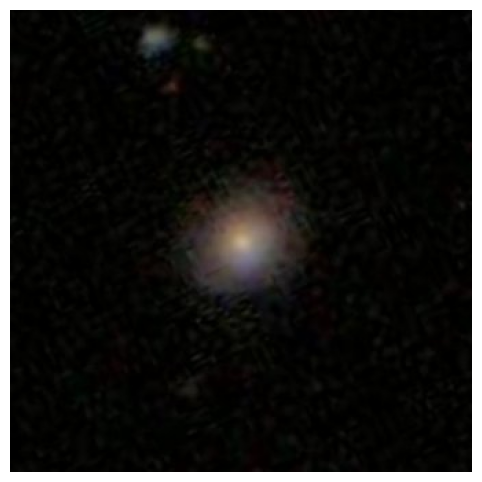

In [10]:
sample = dataset.data[8]
img_path = sample["image"]

plt.figure(figsize=(8, 6))
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')

print("TRUTH:", sample["text"])
print("PREDICTED:", test_model(model, processor, img_path))

In [10]:
# Training configuration - full FP32 to avoid all gradient issues
training_args = TrainingArguments(
    output_dir="./tiny-llava-trained",         # Where to save model checkpoints
    num_train_epochs=1,                        # How many times to go through the dataset
    per_device_train_batch_size=8,             # Process 1 example at a time (small for memory)
    learning_rate=5e-5,                        # How fast the model learns (small = careful)
    logging_steps=500,                         # Print progress every N training steps
    save_strategy="no",                        # Don't save checkpoints (workshop demo only)
    eval_strategy="no",                        # Don't evaluate during training (keep simple)
    remove_unused_columns=False,               # Keep all data columns for LLaVA
    fp16=False,                                # Disable half-precision (avoids gradient issues)
    bf16=False,                                # Disable bfloat16 (avoids gradient issues)
    report_to="none",                          # Don't send metrics to tracking services
    dataloader_num_workers=0,                  # Use main thread only (avoids multiprocessing issues)
    dataloader_pin_memory=False                # Disable memory pinning (avoids GPU memory issues)
)

In [6]:
from peft import LoraConfig, get_peft_model

lora_cfg = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","o_proj"]
)

In [14]:
import torch

def collate_fn(features):
    # features is a list of dicts, each with keys:
    #   'input_ids', 'attention_mask', 'pixel_values', 'labels'

    # 1) stack pixel_values (all same shape: 3×336×336)
    pixel_values = torch.stack([f["pixel_values"] for f in features])

    # 2) gather input_ids & attention_mask for text, pad them to same length
    batch_text = {
        "input_ids":      [f["input_ids"] for f in features],
        "attention_mask": [f["attention_mask"] for f in features],
    }
    batch_text = processor.tokenizer.pad(
        batch_text,
        padding="longest",
        return_tensors="pt"
    )

    # 3) labels: pad/truncate to same as input_ids
    #    if you already have f["labels"], you can pad those directly:
    batch_labels = processor.tokenizer.pad(
        {"input_ids": [f["labels"] for f in features]},
        padding="longest",
        return_tensors="pt"
    )["input_ids"]

    # 4) assemble final batch
    batch = {
        "pixel_values": pixel_values,
        "input_ids":    batch_text["input_ids"],
        "attention_mask": batch_text["attention_mask"],
        "labels":       batch_labels,
    }
    return batch


🚀 Starting TinyLLaVA LoRA fine-tuning…
Setting up TinyLLaVA...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Fixed patch_size
✓ Model and processor ready
trainable params: 1,126,400 || all params: 1,411,829,760 || trainable%: 0.0798

Testing BEFORE training:


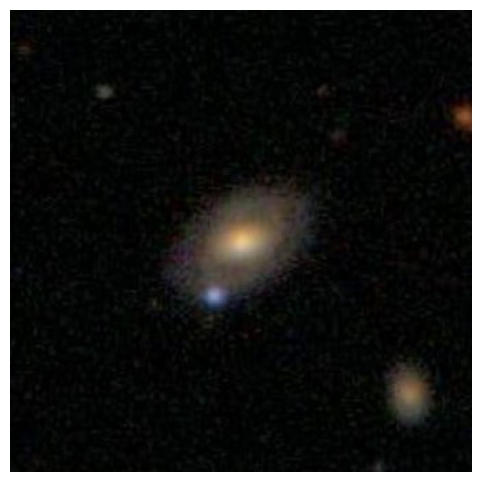

/tmp/ipython-input-3683360267.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


BEFORE: The image features a large, bright, and colorful star cluster in the middle of a dark, empty space. The star cluster is surrounded by a vast, dark, empty space, which appears to be a vast, empty, and dark galaxy

Starting training…


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


✓ Training completed!

Testing AFTER training:
AFTER: This is a 3D image of a galaxy, which is a spiral-shaped object with a central point of light. The galaxy is composed of many smaller objects, such as stars, and is also known as a spiral
Adapters saved to tinyllava_gz2_lora/


In [15]:
# 🚀 TinyLLaVA + LoRA fine-tuning on Galaxy Zoo 2
# ------------------------------------------------
print("🚀 Starting TinyLLaVA LoRA fine-tuning…")
print("=" * 30)

from peft import prepare_model_for_kbit_training

# 1. base weights + processor
model, processor = setup_tiny_llava()   # our existing helper

# 2. attach LoRA adapters (only proj/FFN layers train)
model = get_peft_model(model, lora_cfg)

# 3. freeze **only** the vision‐tower LoRA weights
for name, param in model.named_parameters():
    if "vision_tower" in name and "lora_" in name:
        param.requires_grad = False

model.print_trainable_parameters()

# 3. dataset
dataset = GZ2LLaVADataset("gz2_llava_hf/gz2_llava.jsonl", processor)

# ------Test before training -----
print("\nTesting BEFORE training:")
sample_item = dataset.data[0]
test_image = f"{sample_item['image']}"
before_response = test_model(model, processor, test_image)

plt.figure(figsize=(8, 6))
img = Image.open(test_image)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"BEFORE: {before_response}")
# -------------------------------

# 5. trainer (reduce LR for LoRA)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer = processor.tokenizer, # Trainer expects “tokenizer”
    data_collator=collate_fn,
)

print("\nStarting training…")
trainer.train()
print("✓ Training completed!")

# 6. test after
print("\nTesting AFTER training:")
print("AFTER:", test_model(model, processor, test_image))

# 7. save lightweight adapters (~40 MB)
model.save_pretrained("tinyllava_gz2_lora")
print("Adapters saved to tinyllava_gz2_lora/")


In [19]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=250, training_loss=4.07747216796875, metrics={'train_runtime': 421.0046, 'train_samples_per_second': 4.751, 'train_steps_per_second': 0.594, 'total_flos': 1.006285362315264e+16, 'train_loss': 4.07747216796875, 'epoch': 1.0})

TRUTH: This is an image of a spiral galaxy, with two arms, disturbed or merging with another galaxy.
PREDICTED: This is a model of a graph,) of the Milest, the,,,,,,,,,,,,,,,,,


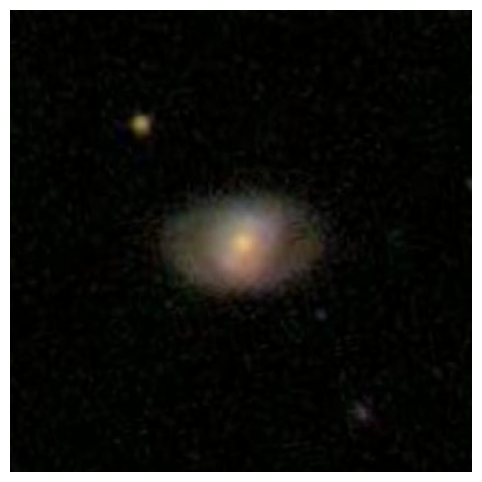

In [21]:
sample = dataset.data[4]
img_path = sample["image"]

plt.figure(figsize=(8, 6))
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')

print("TRUTH:", sample["text"])
print("PREDICTED:", test_model(model, processor, img_path))

observations:
- converge in roughly the same # of steps
- but to a much higher loss val
(what loss is used? same interpretation, surely? questions about start loss in full fine tuning being lower)